In [1]:
#Finding reasonable cells from other patients
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Import the data and flip into a multi index 
df = pd.read_csv('../Data/allele_counts.tsv', header = [0,1,2], index_col = 0, sep='\t')
df = df.stack([0,1,2])
df = df.reorder_levels([1,0,2,3])
df = df.to_frame()  #puts everything back in a dataframe
df.columns = ['Reads']
df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
df['Well'] = df.index.get_level_values(1)
df['Amplicon'] = df.index.get_level_values(2)
df['Genotype'] = df.index.get_level_values(3)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two'])

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

#Make a dictionary to associate plates with patients and plate with cell type
plate_pt_dict = dict(zip(key.Plate, key.Patient))
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

#Set up some lists for iteration
patients = ['RN', 'EL', 'GR']
plates = df['Plate'].drop_duplicates().to_list()
amplicons = df['Amplicon'].drop_duplicates().to_list()
genos = df['Genotype'].drop_duplicates().to_list()
wells = df['Well'].drop_duplicates().to_list()

#Now just look at EL data, and apply filters to identify cells with enough reads/amplicon
#EL_allele_plate is the key dataset going forward
EL_allele_plate = df.loc[df['Patient'].isin(['EL'])] #Make df with just RN data
EL_allele_plate = EL_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
EL_allele_plate['Cell_type'] = EL_allele_plate['Plate'].replace(plate_cell_dict)
EL_allele_plate['Plate_Well'] = EL_allele_plate['Plate'].astype(str) + '_' + EL_allele_plate['Well'].astype(str)

#Make list of cell types
celltype = sorted(EL_allele_plate['Cell_type'].drop_duplicates().to_list())
celltype

['CD34+', 'CD34+/38-', 'Monocytes', 'NEs', 'nBCs']

In [115]:
df1 = EL_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
amps = df1.stack()
amps['Amps'] = amps.index.get_level_values(2)
amplicons = amps['Amps'].drop_duplicates().to_list()
#Drop CUX1 allele
#df1 = df1.iloc[:, [1,2,3,4,5]] 
df1['Plate'] = df1.index.get_level_values(0)
df1.columns = ['EL_CUX1','EL_SRSF2', 'EL_TET2a', 'EL_TET2b', 'EL_TGFB3_c', 'EL_TGFB3_g', 'Plate']
df1['Cell_type'] = df1['Plate'].replace(plate_cell_dict)
df1

EL_CUX1  EL_SRSF2  EL_TET2a  EL_TET2b  EL_TGFB3_c  EL_TGFB3_g  \
Plate  Well                                                                  
AS-202 A1        NaN       0.0       1.0       1.0         0.0         0.0   
       A10       NaN       0.0       2.0       0.0         0.0         0.0   
       A11       NaN       0.0      14.0       8.0         0.0         0.0   
       A12       NaN       6.0      33.0      47.0         0.0         3.0   
       A13       NaN      13.0      43.0      41.0         0.0         2.0   
...              ...       ...       ...       ...         ...         ...   
AS-210 P5        0.0       0.0      17.0      21.0         1.0        20.0   
       P6        0.0      13.0       0.0       2.0         0.0         0.0   
       P7        0.0       0.0       1.0       3.0         0.0         0.0   
       P8        0.0      21.0       3.0       4.0         0.0         0.0   
       P9        0.0      16.0       1.0       3.0         0.0         2.0   

              Plate  Cell_type  
Plate  Well                     
AS-202 A1    AS-202  Monocytes  
       A10   AS-202  Monocytes  
       A11   AS-202  Monocytes  
       A12   AS-202  Monocytes  
       A13   AS-202  Monocytes  
...             ...        ...  
AS-210 P5    AS-210  CD34+/38-  
       P6    AS-210  CD34+/38-  
       P7    AS-210  CD34+/38-  
       P8    AS-210  CD34+/38-  
       P9    AS-210  CD34+/38-  

[3456 rows x 8 columns]

Text(0.5, 1.0, 'TGFb3 cDNA reads per cell')

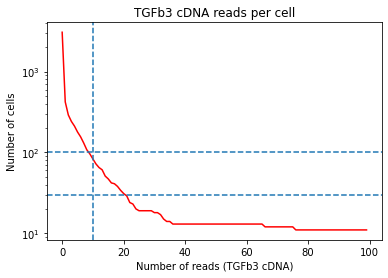

In [116]:
fig, ax = plt.subplots()
x = []
y = []

for read in range(100):
    
    y.append(df1.loc[df1['EL_TGFB3_c'] >= read].shape[0])
    x.append(read)
    
#print(x, y)    
ax.plot(x, y, color = 'red')
ax.set_yscale('log')
ax.axvline(10, ls = '--')  
ax.set_xlabel('Number of reads (TGFb3 cDNA)')
ax.set_ylabel('Number of cells')
ax.axhline(100, ls = '--')
ax.axhline(30, ls = '--')
ax.set_title('TGFb3 cDNA reads per cell')


In [119]:
df2 = df1.loc[df1['EL_TGFB3_c'] >= 18]
df2 = df2.loc[df2['Plate'].isin(['AS-208'])]
print(df2.shape[0])
print(df2['Plate'].drop_duplicates().to_list())
print(df2)
df2.to_csv('../Results/Geno_counts/EL_TGFb3_c at least 18 reads plate AS-208.csv')
#sns.barplot(x='Plate', y='EL_TGFB3_c', data=df1) #Av TGFb_c reads per well per plate
#amplicons

33
['AS-208']
             EL_CUX1  EL_SRSF2  EL_TET2a  EL_TET2b  EL_TGFB3_c  EL_TGFB3_g  \
Plate  Well                                                                  
AS-208 B8        NaN     186.0     302.0     400.0        19.0         6.0   
       C11       NaN      52.0     383.0     514.0       167.0         0.0   
       C13       NaN    2236.0    4517.0    6031.0        18.0         3.0   
       C16       NaN    1799.0     484.0    1962.0        18.0         1.0   
       C19       NaN     460.0     284.0     463.0        23.0         3.0   
       C23       NaN     122.0    5688.0     343.0        24.0         0.0   
       C8        NaN     344.0     434.0     569.0        33.0         6.0   
       D8        NaN     149.0     277.0     349.0        21.0         4.0   
       E14       NaN      10.0      60.0     123.0        19.0         1.0   
       E19       NaN    2318.0     416.0    3173.0        21.0         6.0   
       E23       NaN     412.0     623.0     404.0